# Final Project

MSc in Data Science and Business Analytics - Statistics and Probability 2023/2024
Group 20:
- Giovanni Carboniero (3080265)
- Matteo Casati (3128053)
- Lorenzo Costa (3120759)
- Leonardo Dusini (3141506)
- Fabio Sacerdote (3121315)

## Data import and libraries

In [1]:
import pandas as pd
import numpy as np
import os
from numpy.linalg import multi_dot, inv
import matplotlib.pyplot as plt
from scipy.stats import norm, multivariate_normal, gamma
import statsmodels.api as sm
from tabulate import tabulate

In [2]:
input_file_name = os.path.join(os.getcwd(),'SAheart.txt')
with open(input_file_name, 'rt') as input_file:
    data = input_file.read()
    
temp = []
for i in data.splitlines():
    temp.append(i.split())
    
df = pd.DataFrame(temp[1:], columns = [i.strip('"') for i in temp[0]])

for c in df.columns:
    if c != "famhist":
        df[c] = df[c].astype(float)

df['famhist_enc'] = df['famhist'].apply(lambda x: 1 if x=='"Present"' else 0)
df['intercept'] = np.ones(len(df))

In [3]:
Y = np.array(df['chd']).reshape(-1, 1)
X = np.array(df.drop(['chd', 'famhist'], axis = 1))

n, d = X.shape

## Fisher scoring for Probit regression

Probit regression is part of the family of Generalized Linear Models with:
- random component $Y_i \sim Bernoulli\left(\mu_i\right)$ (which belongs to the exponential family with parameters $\theta$ and $\phi$)
- deterministic component $\eta_i = X_i^T \beta$
- link function $g(\mu_i) = \Phi^{-1}(\mu_i) = \eta_i$ which implies $\mu_i = \Phi(X_i^T\beta)$

For GLM we can apply the Fisher Scoring algorithm and compute the parameters $\beta$ by:
- initializing $\beta_0$
- at each iteration computing $\beta_{t+1} = \left(X^TW_{t}X\right)^{-1}X^TW_tZ_t$ until a stopping condition is reached

Where the matrices are computed as:
$$
W_{ii} = \frac{1}{\text{Var}(y_i)} \left(\frac{d \eta_i}{d \mu_i}\right)^{-2} \\
Z_i = \eta_i +(Y_i -\mu_i)\left(\frac{d \eta_i}{d \mu_i} \right) 
$$
with
$$
\frac{d \eta_i}{d \mu_i} = \frac{1}{\Phi'(\Phi^{-1}(\mu_i))} = \frac{1}{\Phi'(\eta_i)} = e^{\eta_i^2/2} \sqrt{2\pi} \\
Var(y_i) = \Phi(\eta_i)\left(1-\Phi(\eta_i) \right) = \mu_i(1-\mu_i)
$$
and the stopping condition is:
$$
\frac{\sqrt{\sum_{k=0}^p (b_k - b_{0, k})^2}}{ \epsilon + \sqrt{\sum_{k=0}^p b_{0,k}}} < \epsilon
$$
reference: Fox, J. (2016). Applied regression analysis and generalized linear models (3rd ed ed.). SAGE Publications.

In [4]:
def probit(X,Y, epsilon, init='zero'):
    n,p = np.shape(X)

    if init=='one':
        b_0 = np.ones((p,1))
    if init=='zero':
        b_0 = np.zeros((p,1))
    if init=='random':
        b_0 = np.random.rand(p,1)

    const = np.sqrt(2*np.pi)
    eta = np.dot(X,b_0)
    mu = norm.cdf(eta)
    var = mu*(1-mu) + epsilon
    drv = np.exp(0.5*eta**2) * const + epsilon

    W = np.diag((var**-1 * drv**-2).reshape(n,))
    Z = eta+(Y-mu)*drv #Z

    convergence = False
    c = 0

    coef_history = []

    while not convergence:
        b = multi_dot([inv(multi_dot([np.transpose(X), W, X])),np.transpose(X),W,Z])
        eta = np.dot(X,b)
        mu = norm.cdf(eta)
        var = mu*(1-mu) + epsilon
        drv = np.exp(0.5*eta**2)*const + epsilon

        W = np.diag((var**-1 * drv**-2).reshape(n,))
        Z = eta+(Y-mu)*drv #Z

        coef_history.append(b.copy())

        if np.linalg.norm(b-b_0)/(np.linalg.norm(b_0)+epsilon) < epsilon:
            convergence = True
        b_0 = b
        c += 1
    return b, c, np.array(coef_history), X, W, var, mu

In [5]:
np.random.seed(35)
epsilon = 0.000001

b, c, coef_history, X, W, var, mu = probit(X,Y, epsilon=0.00000001, init='zero')

After finding the estimates for the coefficients we can use the quantities computed in the last iteration to find standard errors using the formula:
$$
se(\hat{\beta}) = \hat{\phi} (\mathbf{X^T W X})^{-1} \quad \text{where} \; \hat{\phi} = \frac{1}{n-k-1}\sum \frac{(Y_i - \hat{\mu})^2}{Var(Y_i)}
$$
Another statistic that is useful to compute are the marginal effects which measure the change in the probability of $Y_i = 1$ given a marginal change in the regressors. In the case of Probit regression the coefficients found by the model reflect the change in that probability measured by the link function (Probit function $\Phi^{-1}$. We can therefore find the actual marginal effect as:
$$
\frac{\partial P(Y_i = 1 | X_{i1}, \ldots, X_{iK}; \beta_0, \ldots, \beta_K)}{\partial X_{ki}} = \beta_k \phi(\beta_0 + \sum_{k=1}^{K} \beta_k X_{ki})
$$
Clearly the marginal effect for one variable depends on the values of the other regressors therefore a possible way to report them (chosen here) is to use Average Marginal Effects, that is calculate marginal effects for all variables and then averging them.

Fox, J. (2016). Applied regression analysis and generalized linear models (3rd ed ed.). SAGE Publications.

In [6]:
def probit_marginal_effects(X, beta):
    eta = np.dot(X, beta)
    pdf_at_eta = norm.pdf(eta)
    marginal_effects = pdf_at_eta[:, np.newaxis] * beta.T
    average_marginal_effects = np.mean(marginal_effects, axis=0)
    return average_marginal_effects

In [7]:
# Standard Errors
n = len(X)
k = len(b)
ni = (Y==1).sum()
t1 = inv(X.T @ W @ X)
t2 = ((Y-mu)**2/var).sum()
phi = 1/(n-k-1) * t2
standard_errors = np.sqrt((phi * t1).diagonal())

# P-values
z_scores = b.flatten() / standard_errors
p_values = 2 * norm.sf(np.abs(z_scores))

# Confidence Intervals
z = norm.ppf(0.975)  # This gives approximately 1.96
conf_int_lower = b.flatten() - z * standard_errors
conf_int_upper = b.flatten() + z * standard_errors
confidence_intervals = np.column_stack((conf_int_lower, conf_int_upper))

# Average Marginal Effects 
marginal_effects = probit_marginal_effects(X, b)

final_table = pd.DataFrame({
    'Coefficient': np.round(b.flatten(),4),
    'Standard Error': np.round(standard_errors,4),
    'P-value': np.round(p_values,4),
    'CI Lower Bound': np.round(conf_int_lower,4),
    'CI Upper Bound': np.round(conf_int_upper,4)
})

We can have a look at the convergence of the coefficients

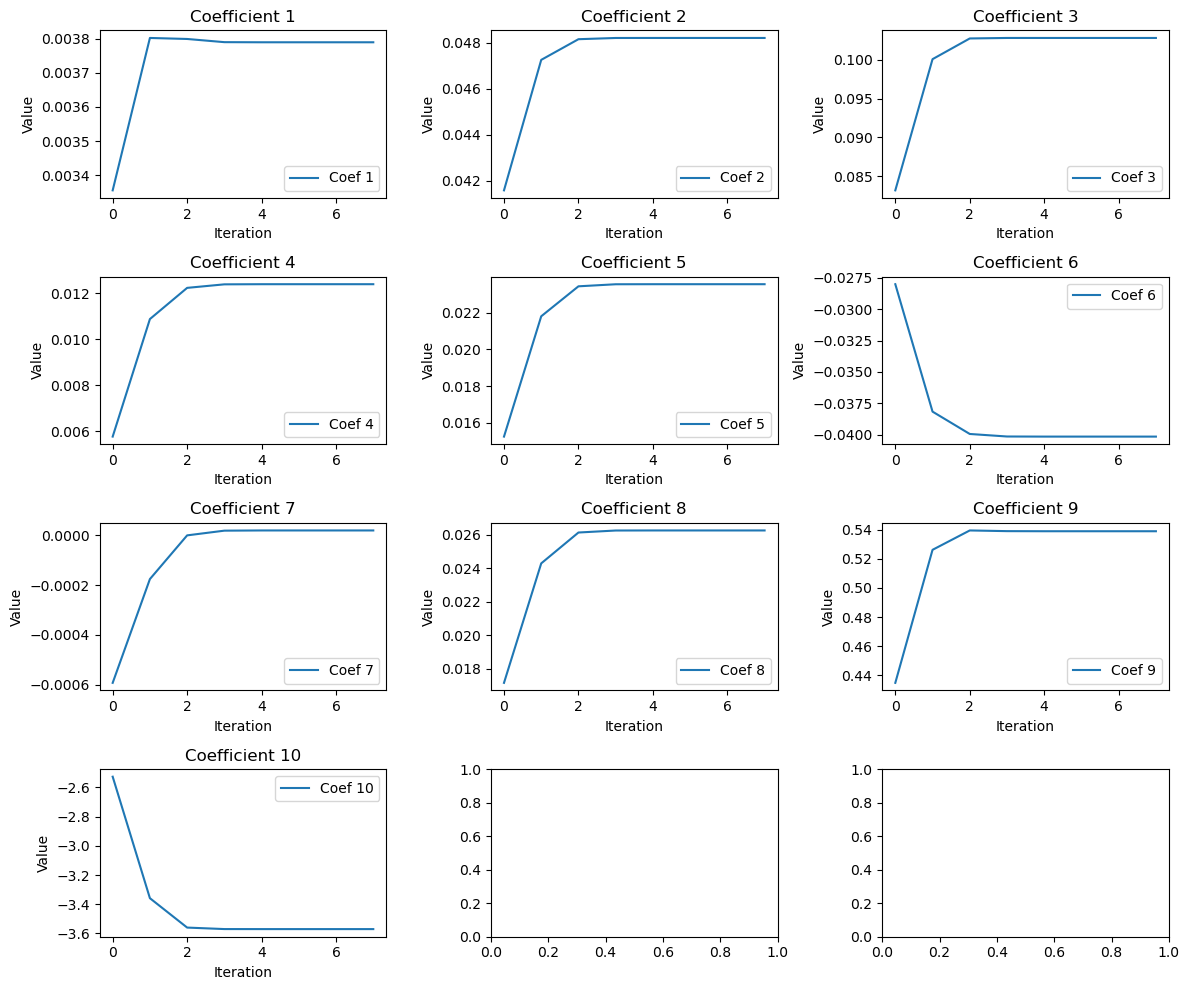

In [8]:
import matplotlib.pyplot as plt

num_coef = coef_history.shape[1]
num_rows = int(np.ceil(num_coef / 3))
fig, axes = plt.subplots(4, 3, figsize=(12, 10))

for i in range(num_coef):
    row = i // 3
    col = i % 3
    ax = axes[row, col]
    ax.plot(coef_history[:, i], label=f'Coef {i+1}')
    ax.set_title(f'Coefficient {i+1}')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Value')
    ax.legend()

plt.tight_layout()
plt.show()

### Results

To check that the implementation of our algorithm is correct we also fit a Probit regression with the library *statsmodels*. \
Not surprisingly the results are (almost) equal. Indeed statsmodels uses precisely the Fisher Scoring method.

In [9]:
import statsmodels.api

model = statsmodels.api.Probit(Y, df.drop(['chd', 'famhist'], axis = 1))
m = model.fit()
print(m.summary())

Optimization terminated successfully.
         Current function value: 0.510740
         Iterations 6
                          Probit Regression Results                           
Dep. Variable:                      y   No. Observations:                  462
Model:                         Probit   Df Residuals:                      452
Method:                           MLE   Df Model:                            9
Date:                Mon, 05 Feb 2024   Pseudo R-squ.:                  0.2083
Time:                        19:22:56   Log-Likelihood:                -235.96
converged:                       True   LL-Null:                       -298.05
Covariance Type:            nonrobust   LLR p-value:                 1.856e-22
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
sbp             0.0038      0.003      1.104      0.269      -0.003       0.011
tobacco         0.0482    

In [10]:
print(tabulate(final_table, headers='keys', tablefmt='pretty'))

+---+-------------+----------------+---------+----------------+----------------+
|   | Coefficient | Standard Error | P-value | CI Lower Bound | CI Upper Bound |
+---+-------------+----------------+---------+----------------+----------------+
| 0 |   0.0038    |     0.0035     | 0.2722  |     -0.003     |     0.0106     |
| 1 |   0.0482    |     0.0159     | 0.0025  |     0.017      |     0.0795     |
| 2 |   0.1028    |     0.0355     | 0.0038  |     0.0332     |     0.1725     |
| 3 |   0.0124    |     0.0175     | 0.4788  |    -0.0219     |     0.0467     |
| 4 |   0.0236    |     0.0072     | 0.0011  |     0.0094     |     0.0377     |
| 5 |   -0.0402   |     0.0265     | 0.1291  |     -0.092     |     0.0117     |
| 6 |     0.0     |     0.0027     | 0.9942  |    -0.0053     |     0.0053     |
| 7 |   0.0263    |     0.0071     | 0.0002  |     0.0124     |     0.0402     |
| 8 |    0.539    |     0.1357     | 0.0001  |     0.2729     |     0.805      |
| 9 |   -3.5702   |     0.75